**Автор**: Ермекова Асель

В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

* **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
* **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.





     

Установите библиотеку для подсчета FID:

In [1]:
!pip install pytorch-fid

## **I часть. Unconditional VAE (6 баллов)**

### Библиотеки

In [2]:
# TODO
# Импортните любые необходимые вам библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

### Датасет.

**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.

In [3]:
# --- Подготовка данных ---
batch_size = 128  # Размер батча

# Визуально переформатированный пайплайн преобразований
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Загрузка датасета MNIST для обучения
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Создание загрузчика данных
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)


test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 128MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 34.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 63.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.00MB/s]


**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку

In [4]:
# TODO: Для FID сохраните 10k реальных изображений из MNIST test части в папку

# Создаем целевую директорию для хранения реальных изображений

# Папка для сохранения реальных изображений
real_images_dir = 'mnist_vae_real'
os.makedirs(real_images_dir, exist_ok=True)

num_images_to_save = 10000
saved_count = 0

# Сохранение 10 000 реальных изображений
for i, (img, label) in enumerate(test_dataset):
    if saved_count >= num_images_to_save:
        break

    # Нормализация [0, 1] -> [0, 255] и конвертация в PIL Image
    img = img * 0.5 + 0.5  # Денормализация из [-1, 1] -> [0, 1]
    img = transforms.ToPILImage()(img)

    img_path = os.path.join(real_images_dir, f'real_mnist_{i}.png')
    img.save(img_path)
    saved_count += 1

print(f"Сохранено {saved_count} реальных изображений MNIST в папку '{real_images_dir}'")

Сохранено 10000 реальных изображений MNIST в папку 'mnist_vae_real'


**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных

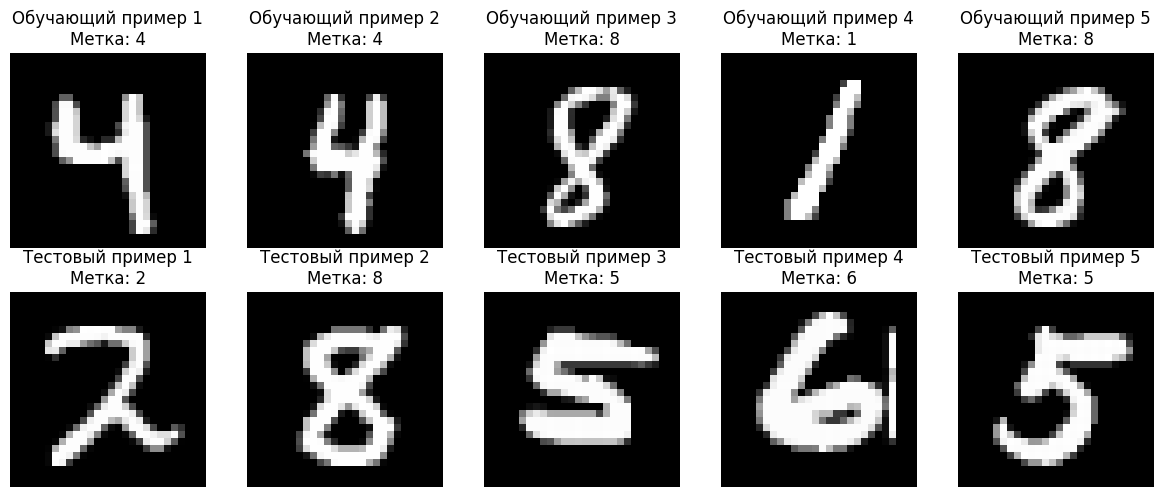

In [5]:
# TODO
fig, axes = plt.subplots(2, 5, figsize = (12, 5))

# Отображение примеров из обучающей выборки
for idx in range(5):
    sample_idx = random.randint(0, len(train_dataset)-1)
    image, target = train_dataset[sample_idx]
    axes[0, idx].imshow(image[0], cmap = 'gray')
    axes[0, idx].set_title(f'Обучающий пример {idx+1}\nМетка: {target}')
    axes[0, idx].axis('off')

# Отображение примеров из тестовой выборки
for j in range(5):
    sample_idx = random.randint(0, len(test_dataset) - 1)
    image, target = test_dataset[sample_idx]
    axes[1, j].imshow(image[0], cmap='gray')
    axes[1, j].set_title(f'Тестовый пример {j+1}\nМетка: {target}')
    axes[1, j].axis('off')

plt.tight_layout()
plt.show()

### Модель

**Задание**: Реализуйте VAE архитектуру

In [6]:
# ODO: РеализуTйте VAE (безусловный)
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim
        self.img_size_flat = 28 * 28

        # Encoder layers
        self.encoder_fc1 = nn.Linear(self.img_size_flat, 1024)
        self.encoder_mu = nn.Linear(1024, latent_dim)
        self.encoder_logvar = nn.Linear(1024, latent_dim)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(latent_dim, 1024)
        self.decoder_fc2 = nn.Linear(1024, self.img_size_flat)

    def encode(self, x):
        # Приводим вход к форме (batch_size, 784)
        x = x.reshape(x.size(0), -1)

        # Скрытое представление
        hidden = F.relu(self.encoder_fc1(x))

        # Параметры распределения
        mu = self.encoder_mu(hidden)
        logvar = self.encoder_logvar(hidden)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Дисперсия -> стандартное отклонение
        sigma = torch.exp(logvar * 0.5)

        # Случайный шум
        noise = torch.randn_like(sigma)

        # Семплирование латентного вектора
        z = mu + noise * sigma
        return z

    def decode(self, z):
        # Восстановление изображения из латентного пространства
        hidden = F.relu(self.decoder_fc1(z))
        x_hat = self.decoder_fc2(hidden)

        # Сигмоида и возврат к форме изображения
        x_hat = torch.sigmoid(x_hat)
        return x_hat.view(-1, 1, 28, 28)

    def forward(self, x):
        # Кодирование
        mu, logvar = self.encode(x)

        # Репараметризация
        z = self.reparameterize(mu, logvar)

        # Декодирование
        reconstructed = self.decode(z)

        return reconstructed, mu, logvar


### Loss

**Задание**: Напишите VAE Loss

In [7]:
# TODO: Реализуйте функцию потерь VAE
def vae_loss(recon_x, x, mu, logvar):
    # Денормализуем x обратно в диапазон [0, 1] для BCE
    x_denormalized = (x * 0.5) + 0.5

    # Потери на реконструкцию: Binary Cross-Entropy, усредненные по элементам и суммированные по батчу
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 28*28), x_denormalized.view(-1, 28*28), reduction='sum')


    # KL-дивергенция: 0.5 * sum(1 + logvar - mu^2 - exp(logvar)), усредненная по батчу
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss

### Тренировка

**Задание**: Обучите модель на датасете MNIST.

In [8]:
latent_dim = 35
epochs = 100
lr = 1e-3
img_size = 28
channels = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# TODO: Обучите модель

# Установим устройство (GPU, если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Обучение...
print("Начинается обучение VAE...")
for epoch in range(epochs):
    model.train() # Устанавливаем модель в режим обучения
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch: {epoch+1}/{epochs}, Average loss: {train_loss / len(train_loader.dataset):.4f}')

print("Обучение VAE завершено.")


Используется устройство: cpu
Начинается обучение VAE...
Epoch: 1/100, Average loss: 149.3864
Epoch: 2/100, Average loss: 118.2362
Epoch: 3/100, Average loss: 112.8695
Epoch: 4/100, Average loss: 110.4641
Epoch: 5/100, Average loss: 108.9930
Epoch: 6/100, Average loss: 108.0384
Epoch: 7/100, Average loss: 107.4125
Epoch: 8/100, Average loss: 106.8762
Epoch: 9/100, Average loss: 106.3951
Epoch: 10/100, Average loss: 106.0279
Epoch: 11/100, Average loss: 105.7366
Epoch: 12/100, Average loss: 105.5262
Epoch: 13/100, Average loss: 105.2689
Epoch: 14/100, Average loss: 104.9900
Epoch: 15/100, Average loss: 104.8051
Epoch: 16/100, Average loss: 104.6025
Epoch: 17/100, Average loss: 104.4310
Epoch: 18/100, Average loss: 104.2449
Epoch: 19/100, Average loss: 104.0343
Epoch: 20/100, Average loss: 103.8993
Epoch: 21/100, Average loss: 103.7118
Epoch: 22/100, Average loss: 103.5779
Epoch: 23/100, Average loss: 103.4882
Epoch: 24/100, Average loss: 103.3141
Epoch: 25/100, Average loss: 103.1738
Epo

### Метрика

В этом разделе вам необходимо посчитать метрику FID.

**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:
- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.

**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.

In [10]:
# TODO: Сгенерируйте и сохраните 10 тыс. изображений для FID в папке mnist_vae_fake
# Каталог для сохранения сгенерированных изображений
fake_images_dir = 'mnist_vae_fake'
os.makedirs(fake_images_dir, exist_ok=True)

num_images_to_generate = 10000
saved_count_fake = 0

# Переключаем модель в режим инференса
model.eval()

with torch.no_grad():
    idx = 0
    while idx < num_images_to_generate:
        # Сэмплируем точку из латентного пространства
        z = torch.randn(1, latent_dim, device=device)

        # Получаем изображение из декодера
        output = model.decode(z)
        output = output.detach().cpu()

        # Приводим изображение к диапазону [0, 1]
        img = output[0] * 0.5 + 0.5

        # Конвертация в PIL и сохранение
        pil_img = transforms.ToPILImage()(img)
        file_name = f'fake_mnist_{idx}.png'
        pil_img.save(os.path.join(fake_images_dir, file_name))

        saved_count_fake += 1
        idx += 1

print(
    f"Сгенерировано и сохранено {saved_count_fake} "
    f"фейковых изображений MNIST в папку '{fake_images_dir}'"
)


Сгенерировано и сохранено 10000 фейковых изображений MNIST в папку 'mnist_vae_fake'


In [11]:
# Чтобы вычислить FID, запустите в терминале:
!pip install pytorch-fid
!python -m pytorch_fid mnist_vae_real mnist_vae_fake --device cpu

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 197MB/s]
100% 200/200 [57:01<00:00, 17.11s/it]
100% 200/200 [58:38<00:00, 17.59s/it]
FID:  45.42977252628765


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.


**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Conditional Variational Autoencoder (CVAE)
# Условие (класс) подается как one-hot вектор и используется
# как в encoder, так и в decoder
class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_size_flat = 28 * 28

        # ---------- Encoder ----------
        # Вход: [x_flat, c]
        # x_flat — изображение, развернутое в вектор (784)
        # c       — one-hot вектор класса (num_classes)
        self.encoder_fc1 = nn.Linear(self.img_size_flat + self.num_classes, 1024)
        self.encoder_mu = nn.Linear(1024, latent_dim)
        self.encoder_logvar = nn.Linear(1024, latent_dim)

        # ---------- Decoder ----------
        # Вход: [z, c]
        # z — латентный вектор
        # c — one-hot вектор класса
        self.decoder_fc1 = nn.Linear(latent_dim + self.num_classes, 1024)
        self.decoder_fc2 = nn.Linear(1024, self.img_size_flat)

    def encode(self, x, c):
        """
        Кодировщик: получает изображение и класс,
        возвращает параметры распределения q(z|x,c)
        """
        # Преобразуем изображение в плоский вектор
        x_flat = x.view(-1, self.img_size_flat)

        # Объединяем изображение и условие (класс)
        enc_input = torch.cat([x_flat, c], dim=1)

        h = F.relu(self.encoder_fc1(enc_input))
        mu = self.encoder_mu(h)
        logvar = self.encoder_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Репараметризация:
        z = mu + eps * sigma, где eps ~ N(0, I)
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        """
        Декодировщик: восстанавливает изображение
        по латентному вектору и классу
        """
        # Объединяем латентный вектор и условие
        dec_input = torch.cat([z, c], dim=1)

        h = F.relu(self.decoder_fc1(dec_input))
        # Sigmoid — так как значения пикселей в [0, 1]
        return torch.sigmoid(self.decoder_fc2(h))

    def forward(self, x, c):
        """
        Полный проход CVAE:
        x, c → encoder → z → decoder → x_recon
        """
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar


In [13]:
# TODO: Обучите CVAE

# ---------- Гиперпараметры CVAE ----------
cvae_latent_dim = 35      # Размер латентного пространства
cvae_epochs = 100         # Количество эпох обучения
cvae_lr = 1e-3            # Скорость обучения
num_classes = 10          # Число классов (MNIST)

# ---------- Устройство ----------
# Используем GPU, если доступен, иначе CPU
cvae_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CVAE используется устройство: {cvae_device}")

# ---------- Модель и оптимизатор ----------
cvae_model = CVAE(cvae_latent_dim, num_classes).to(cvae_device)
cvae_optimizer = optim.Adam(cvae_model.parameters(), lr=cvae_lr)

# ---------- Обучение CVAE ----------
print("Начинается обучение CVAE...")
for epoch in range(cvae_epochs):
    cvae_model.train()  # Переключаем модель в режим обучения
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        # Переносим данные и метки на устройство
        data = data.to(cvae_device)
        labels = labels.to(cvae_device)

        # One-hot кодирование меток классов
        # (batch_size, num_classes)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).float()

        # Обнуляем градиенты перед шагом оптимизации
        cvae_optimizer.zero_grad()

        # Прямой проход
        recon_batch, mu, logvar = cvae_model(data, one_hot_labels)

        # Функция потерь (reconstruction + KL)
        # Та же, что и для обычного VAE
        loss = vae_loss(recon_batch, data, mu, logvar)

        # Обратное распространение ошибки
        loss.backward()
        cvae_optimizer.step()

        train_loss += loss.item()

    # Средний лосс на один элемент датасета
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'CVAE Epoch: {epoch + 1}/{cvae_epochs}, Average loss: {avg_loss:.4f}')

print("Обучение CVAE завершено.")


CVAE используется устройство: cpu
Начинается обучение CVAE...
CVAE Epoch: 1/100, Average loss: 146.7381
CVAE Epoch: 2/100, Average loss: 115.9522
CVAE Epoch: 3/100, Average loss: 110.1441
CVAE Epoch: 4/100, Average loss: 107.4095
CVAE Epoch: 5/100, Average loss: 105.8019
CVAE Epoch: 6/100, Average loss: 104.6746
CVAE Epoch: 7/100, Average loss: 103.7549
CVAE Epoch: 8/100, Average loss: 103.1080
CVAE Epoch: 9/100, Average loss: 102.5276
CVAE Epoch: 10/100, Average loss: 102.0760
CVAE Epoch: 11/100, Average loss: 101.6540
CVAE Epoch: 12/100, Average loss: 101.2538
CVAE Epoch: 13/100, Average loss: 100.9665
CVAE Epoch: 14/100, Average loss: 100.6928
CVAE Epoch: 15/100, Average loss: 100.4989
CVAE Epoch: 16/100, Average loss: 100.1519
CVAE Epoch: 17/100, Average loss: 100.0057
CVAE Epoch: 18/100, Average loss: 99.7106
CVAE Epoch: 19/100, Average loss: 99.5829
CVAE Epoch: 20/100, Average loss: 99.3785
CVAE Epoch: 21/100, Average loss: 99.2606
CVAE Epoch: 22/100, Average loss: 99.0614
CVAE E

In [31]:
import os
import torch
from torchvision import transforms
from PIL import Image

fake_per_class_dir = 'fake_per_class'
real_per_class_dir = 'real_per_class'

os.makedirs(fake_per_class_dir, exist_ok=True)
os.makedirs(real_per_class_dir, exist_ok=True)

num_samples_per_class = 1000

cvae_model.eval()

# --------------------------------------------------
# КРИТИЧНО: правильная размерность latent z
# decoder ожидает z_dim + num_classes = 45
# --------------------------------------------------
latent_dim = 45 - num_classes  # = 35

print(f"Используем latent_dim={latent_dim}, num_classes={num_classes}")

# ==================================================
# 1. Генерация изображений
# ==================================================
print("Генерация изображений для каждого класса...")
with torch.no_grad():
    for c in range(num_classes):
        class_fake_dir = os.path.join(fake_per_class_dir, f'class_{c}')
        os.makedirs(class_fake_dir, exist_ok=True)

        # one-hot класс
        class_one_hot = torch.zeros(1, num_classes, device=cvae_device)
        class_one_hot[0, c] = 1

        for i in range(num_samples_per_class):
            # z правильной размерности
            z = torch.randn(1, latent_dim, device=cvae_device)

            # decode(z, c) — как и требует твоя модель
            generated_image = cvae_model.decode(z, class_one_hot).cpu()

            # [-1,1] → [0,1]
            img = generated_image.view(1, 28, 28)
            img = img * 0.5 + 0.5
            img = transforms.ToPILImage()(img.squeeze(0))

            img.save(
                os.path.join(
                    class_fake_dir,
                    f'fake_mnist_class_{c}_{i}.png'
                )
            )

print("Генерация завершена.")

# ==================================================
# 2. Сохранение реальных изображений
# ==================================================
print("Сохранение реальных изображений для каждого класса...")
real_counts_per_class = {i: 0 for i in range(num_classes)}

for img, label in test_dataset:
    if real_counts_per_class[label] < num_samples_per_class:
        class_real_dir = os.path.join(real_per_class_dir, f'class_{label}')
        os.makedirs(class_real_dir, exist_ok=True)

        img_to_save = img * 0.5 + 0.5
        img_to_save = transforms.ToPILImage()(img_to_save.squeeze(0))

        img_to_save.save(
            os.path.join(
                class_real_dir,
                f'real_mnist_class_{label}_{real_counts_per_class[label]}.png'
            )
        )

        real_counts_per_class[label] += 1

    if all(v == num_samples_per_class for v in real_counts_per_class.values()):
        break

print("Сохранение реальных изображений завершено.")


Используем latent_dim=35, num_classes=10
Генерация изображений для каждого класса...
Генерация завершена.
Сохранение реальных изображений для каждого класса...
Сохранение реальных изображений завершено.


In [24]:
# TODO: Посчитайте FID для каждого класса между сгенерированными и реальными изображениями


In [32]:
import os
import torch
from pytorch_fid import fid_score

# -------------------------------
# Настройки
# -------------------------------
real_root = 'real_per_class'
fake_root = 'fake_per_class'

num_classes = 10
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

fid_per_class = {}

# -------------------------------
# Подсчёт FID по классам
# -------------------------------
print("Подсчёт FID по классам (MNIST-correct)...\n")

for class_id in range(num_classes):
    real_dir = os.path.join(real_root, f'class_{class_id}')
    fake_dir = os.path.join(fake_root, f'class_{class_id}')

    if not os.path.isdir(real_dir):
        raise FileNotFoundError(f"Не найдена папка с реальными изображениями: {real_dir}")
    if not os.path.isdir(fake_dir):
        raise FileNotFoundError(f"Не найдена папка с сгенерированными изображениями: {fake_dir}")

    fid_value = fid_score.calculate_fid_given_paths(
        paths=[real_dir, fake_dir],
        batch_size=batch_size,
        device=device,
        dims=2048
    )

    fid_per_class[class_id] = fid_value
    print(f"FID для класса {class_id}: {fid_value:.4f}")

# -------------------------------
# Средний FID
# -------------------------------
mean_fid = sum(fid_per_class.values()) / num_classes

print("\n===============================")
print(f"Средний FID по классам: {mean_fid:.4f}")
print("===============================")


Подсчёт FID по классам (MNIST-correct)...



100%|██████████| 20/20 [05:58<00:00, 17.94s/it]


FID для класса 0: 66.6585


100%|██████████| 20/20 [06:00<00:00, 18.05s/it]


FID для класса 1: 47.7352


100%|██████████| 20/20 [05:49<00:00, 17.50s/it]


FID для класса 2: 57.0846


100%|██████████| 20/20 [05:56<00:00, 17.81s/it]


FID для класса 3: 53.5098


100%|██████████| 20/20 [05:55<00:00, 17.80s/it]


FID для класса 4: 47.3736


100%|██████████| 20/20 [05:58<00:00, 17.91s/it]


FID для класса 5: 52.5251


100%|██████████| 20/20 [05:53<00:00, 17.68s/it]


FID для класса 6: 58.0574


100%|██████████| 20/20 [05:53<00:00, 17.66s/it]


FID для класса 7: 48.3626


100%|██████████| 20/20 [05:53<00:00, 17.67s/it]


FID для класса 8: 54.6913


100%|██████████| 20/20 [06:06<00:00, 18.31s/it]


FID для класса 9: 49.6083

Средний FID по классам: 53.5606
